# EZKL DEMO

**Learning Objectives**
1. Learn some basic AI/ML techniques by training a toy model in pytorch to perform classification
2. Convert the toy model into zk circuit with ezkl to do provable inference
3. Create a solidity verifier and deploy it on Remix (you can deploy it however you like but we will use Remix as it's quite easy to setup)


**Important Note**: You might want to avoid calling "Run All". There's some file locking issue with Colab which can cause weird bugs. To mitigate this issue you should run cell by cell on Colab.

# Step 1: Training a toy model

For this demo we will use a toy data set called the Iris dataset to demonstrate how training can be performed. The Iris dataset is a collection of Iris flowers and is one of the earliest dataset used to validate classification methodologies.

[More info in the dataset](https://archive.ics.uci.edu/dataset/53/iris)



First, we will need to import all the various dependencies required to train the model

In [1]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import tqdm

Inspect the dataset. Note that for the Iris dataset we have 3 targets.

0 = Iris-setosa

1 = Iris-versicolor

2 = Iris-virginica

In [2]:
iris = load_iris()
dataset = pd.DataFrame(
    data= np.c_[iris['data'], iris['target']],
    columns= iris['feature_names'] + ['target'])
dataset

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2.0
146,6.3,2.5,5.0,1.9,2.0
147,6.5,3.0,5.2,2.0,2.0
148,6.2,3.4,5.4,2.3,2.0


Next, we can begin defining the neural net model. For this dataset we will use a small fully connected neural net.

<br />

**Note:**
For the 1st layer we use 4x20, because there are 4 features we want as inputs. After which we add a ReLU.

For the 2nd layer we use 20x20, then add a ReLU.

And for the last layer we use 20x3, because there are 3 classes we want to classify, then add a ReLU.

The last ReLU function gives us an array of 3 elements where the position of the largest value gives us the target that we want to classify.

For example, if we get [0, 0.001, 0.002] as the output of the last ReLU. As, 0.002 is the largest value, the inferred value is 2.


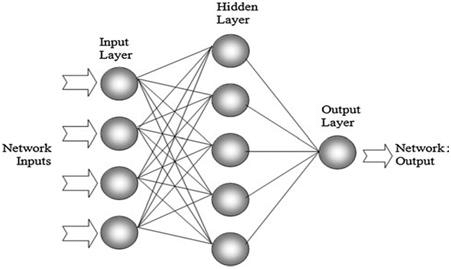

In [3]:
class Model(nn.Module):
    # define nn
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(4, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)

        return x

# Initialize Model
model = Model()

We will now need to split the dataset into a training set and testing set for ML. This is done fairly easily with the `train_test_split` helper function from sklearn.

In [4]:
train_X, test_X, train_y, test_y = train_test_split(
    dataset[dataset.columns[0:4]].values, # use columns 0-4 as X
    dataset.target, # use target as y
    test_size=0.2 # use 20% of data for testing
)

# Uncomment for sanity checks
# print("train_X: ", train_X)
# print("test_X: ", test_X)
print("train_y: ", train_y)
print("test_y: ", test_y)

train_y:  5      0.0
15     0.0
111    2.0
131    2.0
19     0.0
      ... 
88     1.0
11     0.0
110    2.0
10     0.0
24     0.0
Name: target, Length: 120, dtype: float64
test_y:  57     1.0
82     1.0
101    2.0
66     1.0
92     1.0
45     0.0
104    2.0
37     0.0
0      0.0
69     1.0
103    2.0
18     0.0
80     1.0
143    2.0
147    2.0
27     0.0
134    2.0
62     1.0
42     0.0
102    2.0
116    2.0
63     1.0
94     1.0
44     0.0
68     1.0
113    2.0
23     0.0
52     1.0
4      0.0
16     0.0
Name: target, dtype: float64


We can now define the parameters for training, we will use the [Cross Entropy Loss](https://machinelearningmastery.com/cross-entropy-for-machine-learning/) and [Stochastic Gradient Descent Optimizer](https://en.wikipedia.org/wiki/Stochastic_gradient_descent).

In [5]:
# our loss function
loss_fn = nn.CrossEntropyLoss()

# our optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)


# use 800 EPOCHS
EPOCHS = 800

# Convert training data to pytorch variables
train_X = Variable(torch.Tensor(train_X).float())
test_X = Variable(torch.Tensor(test_X).float())
train_y = Variable(torch.Tensor(train_y.values).long())
test_y = Variable(torch.Tensor(test_y.values).long())


loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))


# we use tqdm for nice loading bars
for epoch in tqdm.trange(EPOCHS):

    # To train, we get a prediction from the current network
    predicted_y = model(train_X)

    # Compute the loss to see how bad or good we are doing
    loss = loss_fn(predicted_y, train_y)

    # Append the loss to keep track of our performance
    loss_list[epoch] = loss.item()

    # Afterwards, we will need to zero the gradients to reset
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Calculate the accuracy, call torch.no_grad() to prevent updating gradients
    # while calculating accuracy
    with torch.no_grad():
        y_pred = model(test_X)
        correct = (torch.argmax(y_pred, dim=1) == test_y).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

100%|█████████████| 800/800 [00:00<00:00, 3352.44it/s]


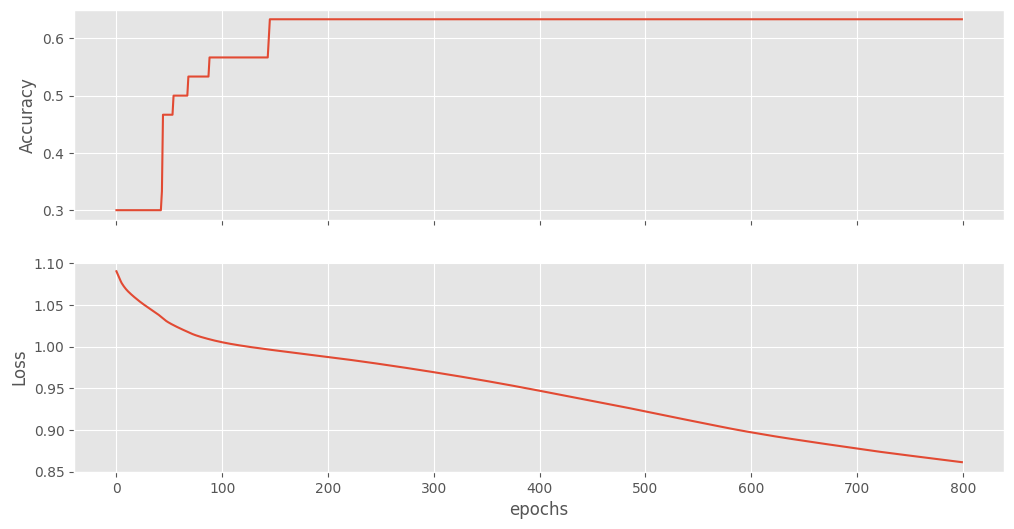

In [6]:
# Plot the Accuracy and Loss

# import matplotlib
import matplotlib.pyplot as plt

plt.style.use('ggplot')


fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("Accuracy")
ax2.plot(loss_list)
ax2.set_ylabel("Loss")
ax2.set_xlabel("epochs");

## Congratulations! You've just trained a neural network

**Exercise:** The model provided is very simplistic, what are other ways the model can be improved upon?

# Step 2: ZK the Neural Network

Now that we have the Neural Network trained, we can use ezkl to easily ZK our model.

To proceed we will now need to install `ezkl`



In [7]:
# check if notebook is in colab
try:
    import google.colab
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "ezkl"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "onnx"])

# rely on local installation of ezkl if the notebook is not in colab
except:
    pass

import os
import json
import ezkl

Next, we will need to export the neural network to a `.onnx` file. ezkl reads this `.onnx` file and converts it into a circuit which then allows you to generate proofs as well as verify proofs

In [8]:
# Specify all the files we need

model_path = os.path.join('network.onnx')
data_path = os.path.join('input.json')
cal_data_path = os.path.join('calibration.json')

In [9]:
# After training, export to onnx (network.onnx) and create a data file (input.json)

# create a random input
x = test_X[0].reshape(1, 4)

# Flips the neural net into inference mode
model.eval()

# Export the model
torch.onnx.export(model,                     # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  model_path,                # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

data_array = ((x).detach().numpy()).reshape([-1]).tolist()

data = dict(input_data = [data_array])

    # Serialize data into file:
json.dump(data, open(data_path, 'w'))





After which we can proceed to generate the settings file for `ezkl` and run calibrate settings to find the optimal settings for `ezkl`

In [10]:
!RUST_LOG=trace
# TODO: Dictionary outputs
res = ezkl.gen_settings()
assert res == True



In [11]:
# use the test set to calibrate the circuit
cal_data = dict(input_data = test_X.flatten().tolist())

# Serialize calibration data into file:
json.dump(data, open(cal_data_path, 'w'))

# Optimize for resources, we cap logrows at 12 to reduce setup and proving time, at the expense of accuracy
# You may want to increase the max logrows if accuracy is a concern
res = await ezkl.calibrate_settings(target = "resources", max_logrows = 12, scales = [2])

Using 5 columns for range-check.
Using 5 columns for range-check.
Using 5 columns for range-check.
Using 5 columns for range-check.
Using 5 columns for range-check.
Using 5 columns for range-check.
Using 5 columns for range-check.
Using 5 columns for range-check.
Using 5 columns for range-check.
Using 5 columns for range-check.
Using 5 columns for range-check.
Using 5 columns for range-check.


 <------------- Numerical Fidelity Report (input_scale: 2, param_scale: 2, scale_input_multiplier: 10) ------------->

+------------+--------------+-----------+-----------+----------------+------------------+---------------+---------------+--------------------+--------------------+------------------------+
| mean_error | median_error | max_error | min_error | mean_abs_error | median_abs_error | max_abs_error | min_abs_error | mean_squared_error | mean_percent_error | mean_abs_percent_error |
+------------+--------------+-----------+-----------+----------------+------------------+---------------+

Next, we will compile the model. The compilation step allow us to generate proofs faster.

In [12]:
res = ezkl.compile_circuit()
assert res == True

Before we can setup the circuit params, we need a SRS (Structured Reference String). The SRS is used to generate the proofs.

In [13]:
res = await ezkl.get_srs()

Now run setup, this will generate a proving key (pk) and verification key (vk). The proving key is used for proving while the verification key is used for verificaton.

In [14]:
res = ezkl.setup()


assert res == True

Using 5 columns for range-check.
Using 5 columns for range-check.


Now, we can generate a proof and verify the proof as a sanity check. We will use the "evm" transcript. This will allow us to provide proofs to the EVM.

In [15]:
# Generate the Witness for the proof

# now generate the witness file
witness_path = os.path.join('witness.json')

res = await ezkl.gen_witness()
assert os.path.isfile(witness_path)

In [16]:
# Generate the proof

proof_path = os.path.join('proof.json')

proof = ezkl.prove(proof_type="single", proof_path=proof_path)

print(proof)
assert os.path.isfile(proof_path)

Using 5 columns for range-check.
Using 5 columns for range-check.


{'instances': [['0000000000000000000000000000000000000000000000000000000000000000', '0000000000000000000000000000000000000000000000000000000000000000', '0000000000000000000000000000000000000000000000000000000000000000']], 'proof': '0x2822df1d9724923a7ecf489e3a53a5652b451279abcc9ce950355fe4ee117e51075320a853cb0b2783368331c1e0ca9e72e0852c62262c89c4cd6f893d5e6a370c3b832f9dbbb418beffa832190ceca9c0691de2a23c1ced89b85b881035b714042d7b1c87bcdd9f2a49f862b9c0db9f4ea7a8b61505695ed1893db25eb9eec10681abeb73fa7ca9fd0b788c40d4379a24f8f00358713deab344d68b77a8d0fb233be1d0614109116b639e2587c28c64af7d19b5a395d3f4e6e0fa2ccdcc8fd10d1790e8bacbfb932d3a150486cfd8fd0d9518d60b5022ce60869d10edd6d77a0d7f9e41de203dcf75606c01a1da2a76b87ac418691911baf498b56abb6eda7c093a967ba5ee2a3dd721e8462a00f625aad724ddf61c89986755e893080d88871af0c2e5d3d84145abedc45c454851925909304938212510ed1d05cf205e7160138cc308fd4db1a028a9b9c88d8ee982d431019d28a3f4a52bf1249cf15c378d22004514a189166fe7cf91e1fee12eb047355a6c63b00107c95dac06fc59d2

In [17]:
# verify our proof

res = ezkl.verify()

assert res == True
print("verified")

Using 5 columns for range-check.


verified


## Congratulations! You have just turned your Neural Network into a Halo2 Circuit!



# Part 3: Deploying the Verifier
Now that we have the circuit setup, we can proceed to deploy the verifier onchain.

We will need to setup `solc=0.8.20` for this.

In [18]:
# check if notebook is in colab
try:
    import google.colab
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "solc-select"])
    !solc-select install 0.8.20
    !solc-select use 0.8.20
    !solc --version

# rely on local installation if the notebook is not in colab
except:
    pass

With solc in our environment we can now create the evm verifier.

In [19]:
sol_code_path = os.path.join('Verifier.sol')
abi_path = os.path.join('Verifier.abi')

res = await ezkl.create_evm_verifier(
        sol_code_path=sol_code_path,
        abi_path=abi_path,
    )

assert res == True
assert os.path.isfile(sol_code_path)

Using 5 columns for range-check.


In [20]:
onchain_input_array = []

# using a loop
# avoiding printing last comma
formatted_output = "["
for i, value in enumerate(proof["instances"]):
    for j, field_element in enumerate(value):
        onchain_input_array.append(ezkl.felt_to_big_endian(field_element))
        formatted_output += '"' + str(onchain_input_array[-1]) + '"'
        if j != len(value) - 1:
            formatted_output += ", "
    if i != len(proof["instances"]) - 1:
        formatted_output += ", "
formatted_output += "]"

# This will be the values you use onchain
# copy them over to remix and see if they verify
# What happens when you change a value?
print("pubInputs: ", formatted_output)
print("proof: ", proof["proof"])

pubInputs:  ["0x0000000000000000000000000000000000000000000000000000000000000000", "0x0000000000000000000000000000000000000000000000000000000000000000", "0x0000000000000000000000000000000000000000000000000000000000000000"]
proof:  0x2822df1d9724923a7ecf489e3a53a5652b451279abcc9ce950355fe4ee117e51075320a853cb0b2783368331c1e0ca9e72e0852c62262c89c4cd6f893d5e6a370c3b832f9dbbb418beffa832190ceca9c0691de2a23c1ced89b85b881035b714042d7b1c87bcdd9f2a49f862b9c0db9f4ea7a8b61505695ed1893db25eb9eec10681abeb73fa7ca9fd0b788c40d4379a24f8f00358713deab344d68b77a8d0fb233be1d0614109116b639e2587c28c64af7d19b5a395d3f4e6e0fa2ccdcc8fd10d1790e8bacbfb932d3a150486cfd8fd0d9518d60b5022ce60869d10edd6d77a0d7f9e41de203dcf75606c01a1da2a76b87ac418691911baf498b56abb6eda7c093a967ba5ee2a3dd721e8462a00f625aad724ddf61c89986755e893080d88871af0c2e5d3d84145abedc45c454851925909304938212510ed1d05cf205e7160138cc308fd4db1a028a9b9c88d8ee982d431019d28a3f4a52bf1249cf15c378d22004514a189166fe7cf91e1fee12eb047355a6c63b00107c95dac06fc59d20

We will exit colab for the next steps. At the left of colab you can see a folder icon. Click on that.


You should see a `Verifier.sol`. Right-click and save it locally.

Now go to [https://remix.ethereum.org](https://remix.ethereum.org).

Create a new file within remix and copy the verifier code over.

Finally, compile the code and deploy. For the demo you can deploy to the test environment within remix.

If everything works, you would have deployed your verifer onchain! Copy the values in the cell above to the respective fields to test if the verifier is working.

**Note that right now this setup accepts random values!**

This might not be great for some applications. For that we will want to use a data attested verifier instead. [See this tutorial.](https://github.com/zkonduit/ezkl/blob/main/examples/notebooks/data_attest.ipynb)

## Congratulations for making it this far!

If you have followed the whole tutorial, you would have deployed a neural network inference model onchain! That's no mean feat!